# Advanced ways to work with chatbot messages in LangGraph apps: Memory with summarized messages
* To create a summary of the conversation will allow us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 013-summarizing-messages.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Create the State
* **In addition to the built-in messages key, we'll now include a custom key (summary)**.

In [3]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

## Create the logic to summarize the conversation
* We'll **define a node to tell the LLM to add the summary, if it exists, to the prompt**.

* Logic to call the model:

In [4]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the LLM model
def call_model(state: State):
    
    # Get the summary if it exists
    summary = state.get("summary", "")

    # If there is a summary, add it to system message and append it to messages
    if summary:
        
        # Add the summary to the system message
        system_message = f"Summary of previous conversation: {summary}"

        # Append the summary of the conversation to the next messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    # If there is no summary, messages remain as they are
    else:
        messages = state["messages"]
    
    response = chatModel4o.invoke(messages)
    
    return {"messages": response}

#### Code explanation in simple terms

The previous code defines a function called **`call_model`** that interacts with the LLM. Here's a simplified explanation step-by-step:

1. **Input: State**  
The function takes an input called `state`, which stores:  
- **A summary** of previous conversations (optional).  
- **A list of messages** (the current conversation).  

2. **Check for a Summary**  
- **Line: `summary = state.get("summary", "")`**  
  It checks if there’s a summary stored in the `state`. If there isn’t, it defaults to an empty string (`""`).

- **If a summary exists:**  
  - A **system message** is created to include the summary.  
  - The summary is added to the list of messages to give the LLM some context about past conversations.  

- **If no summary exists:**  
  - The messages remain unchanged.

3. **Prepare Messages**  
The `messages` list may now contain:  
    - A **system message** (if a summary is present).  
    - The existing **conversation messages** from the `state`.

4. **Send Messages to the LLM**  
    - The **`model.invoke(messages)`** function sends the prepared messages to the LLM for processing.

5. **Output: New Messages**  
    - The LLM’s response is returned as an updated list of messages in the format:  
  ```python
  {"messages": response}
  ```

* This is the **function we will use to summarize the conversation and to add the summary to messages:**

In [6]:
def summarize_conversation(state: State):
    
    # First, we get the existing summary
    summary = state.get("summary", "")

    # Prompt if summary already exists 
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    # Prompt if summary does not exist yet
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add summary to messages
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    
    response = chatModel4o.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    
    return {"summary": response.content, "messages": delete_messages}

#### Explanation of the previous code in simple terms

The previous code defines a function called **`summarize_conversation`**, which creates or updates a summary of a conversation. Here's a simple explanation step-by-step:

**1. Input: State**  
The function takes an input called `state`, which stores:  
- **A summary** of the conversation (optional).  
- **A list of messages** exchanged so far.

**2. Check for Existing Summary**  
- **`summary = state.get("summary", "")`**  
  Checks if a summary already exists. If not, it defaults to an empty string (`""`).

- **If a summary exists:**  
  - A prompt is created asking the LLM to **extend the existing summary** by including new messages.  

- **If no summary exists:**  
  - A prompt is created asking the LLM to **generate a new summary** from the conversation.

**3. Add Summary Request to Messages**  
- Adds the prompt (request to summarize) as a **new message** to the existing conversation messages.

**4. Send Messages to the LLM**  
- **`model.invoke(messages)`** sends the updated messages to the LLM for processing.  
- The LLM generates a **summary** based on the conversation.

**5. Delete Old Messages**  
- Keeps only the **2 most recent messages** to avoid storing too many messages.  
- Uses **`RemoveMessage`** to mark older messages for deletion.

**6. Return Updated State**  
The function outputs:  
1. **Updated summary** based on the LLM’s response.  
2. **Pruned messages** (keeps only the latest 2 messages).

* We will use a **conditional edge to determine whether to produce a summary based on the conversation length**.
    * If there are more than six messages, we will summarize the conversation:

In [7]:
from langgraph.graph import END

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, 
    # then we will summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## App with the messages summary in memory
* As we saw in a previous lecture when we added short-term memory to our agent, **MemorySaver** is an in-memory key-value store. All we need to do is compile the graph with a checkpointer, and our app has memory.

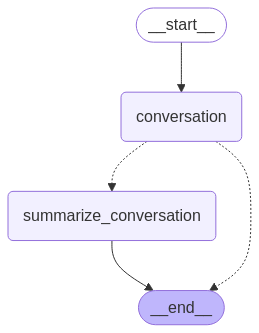

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# PAY ATTENTION HERE: Here we use the first function 
# we defined to create the first node.
# Start conversation with the LLM:
workflow.add_node("conversation", call_model)

# PAY ATTENTION HERE: Here we use the second function 
# we defined to create the second node.
# Summarize the conversation:
workflow.add_node(summarize_conversation)

# Set the entry point as conversation
workflow.add_edge(START, "conversation")

# PAY ATTENTION HERE: Here we use the third function 
# we defined to create a conditional edge.
# If there are more than six messages, go to Summarize the conversation:
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# PAY ATTENTION HERE: See how we add MemorySaver as checkpointer
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Creating a different memory for each thread

In [10]:
model = ChatOpenAI(model="gpt-4o")

# PAY ATTENTION HERE: see how add the thread_id in the config
config = {"configurable": {"thread_id": "1"}}

# Our first message to the chatbot
input_message = HumanMessage(content="Hi! I'm Julio")

# PAY ATTENTION HERE: see how we include the config with the thread_id
output = graph.invoke({"messages": [input_message]}, config) 

# Prints the response from the chatbot
for m in output['messages'][-1:]:
    m.pretty_print()

# Our second message to the chatbot
input_message = HumanMessage(content="what's my name?")

# PAY ATTENTION HERE: see how we include the config with the thread_id
output = graph.invoke({"messages": [input_message]}, config) 

# Prints the response from the chatbot
for m in output['messages'][-1:]:
    m.pretty_print()

# Our third message to the chatbot
input_message = HumanMessage(content="I like the San Francisco Bay")

# PAY ATTENTION HERE: see how we include the config with the thread_id
output = graph.invoke({"messages": [input_message]}, config) 

# Prints the response from the chatbot
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Julio! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Julio. How can I help you further?
================================== Ai Message ==================================

The San Francisco Bay is a beautiful and iconic area known for its stunning views, diverse culture, and vibrant city life. Whether you're interested in exploring the Golden Gate Bridge, Alcatraz Island, or the bustling neighborhoods and culinary scene, there's always something to enjoy. What do you like most about the Bay Area?


In [11]:
# Our fourth message to the chatbot
input_message = HumanMessage(content="The city of San Francisco is not as friendly to live as it used to be")

# PAY ATTENTION HERE: see how we include the config with the thread_id
output = graph.invoke({"messages": [input_message]}, config) 

# Prints the response from the chatbot
for m in output['messages'][-1:]:
    m.pretty_print()

# PAY ATTENTION HERE: now we have 4 inputs and 4 outputs, 
# so in total we have 8 messages (4 inputs + 4 outputs)

================================== Ai Message ==================================

Many people have expressed similar sentiments about living in San Francisco. The city has faced challenges such as high living costs, housing shortages, and issues related to homelessness. These factors can impact the overall quality of life and the sense of community. However, San Francisco still retains its unique charm and cultural vibrancy, which continue to attract people from all over. Are there specific aspects you find challenging, or is there something else you'd like to discuss about the city?


* Let's see the conversation summary:

In [12]:
graph.get_state(config).values.get("summary","")

"Julio introduced himself and expressed a liking for the San Francisco Bay. We discussed the area's beauty, cultural diversity, and attractions like the Golden Gate Bridge and Alcatraz Island. Julio mentioned that living in San Francisco isn't as friendly as it used to be, and we touched on some challenges the city faces, such as high living costs and housing shortages, while acknowledging its ongoing cultural vibrancy."

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 013-summarizing-messages.py
* In terminal, make sure you are in the directory of the file and run:
    * python 013-summarizing-messages.py